

<table>
    <tr>
        <td>&nbsp;</td>
        <td>
            <h1 style="color:blue;text-align:left">Aprendizaje Automático de Maquina: Proyecto 2 </h1></td>
        <td>
            <table><tr>
            <tp><p style="font-size:150%;text-align:center">Redes Neuronales</p></tp>
                <tp><p style="font-size:100%;text-align:center">Andrés Florián </p></tp>
                <tp><p style="font-size:100%;text-align:center">Joseph Mancera </p></tp>
                <tp><p style="font-size:100%;text-align:center">William Lizarazo</p></tp>
            </tr></table>
        </td>
    </tr>
</table>

---

11 de Mayo de 2022

# Proyecto II

El objetivo es generar una red neuronal que pueda reconocer que vocal ha pronunciado una persona.

Para la realización de este proyecto deben:

1. Crear una base de datos con señales de personas diciendo las diferentes vocales. Tenga en cuenta las siguientes consideraciones:
    * Una red aprende con base en la información que le proporcionemos, asi que al crear la base de datos tenga en cuenta todas las posibilidades de como se pueden mencionar esas vocales. Además la base de datos debe contener diferentes muestras de diferentes personas, incluyendo niños, niñas, mujeres y hombres. El objetivo es generalizar, no memorizar patrones, para esto debemos darle suficiente información a la red.
    * Una señal de voz puede tener entre 8000 y 40000 mmuestras por segundo de grabación. Esto es bastante para ser utilizado como entrada en la red. recuerde que entre mayor dimensionalidad en los datos de entrada, mayor será la complejidad de la red necesaria. Para disminuir la complejidad pueden usar la densidad espectral de potencia (PSD) utilizando un número fijo de bins frecuenciales. La PSD representa la distribucion en frecuencia de la potencia de la señal.   
2. Definir las arquitecturas de red que debe probar.
3. Escoger la red que mejor se desempeñe.
4. Evaluar el rendimiento de la red.

Tenga en cuenta que todo el procedimiento debe ser lo mas amigable para probar. Es decir se debe poder probar con cualquier señal, se ingresa la señal de voz y el programa debería indicar que vocal se pronunció.

Deben contestar las siguientes preguntas:

1. ¿Qué puede concluir del comportamiento de la red y los datos proporcionados?
2. ¿Qué criterio utilizó para seleccionar la arquitectura de la red?
3. ¿Tiene la red el comportamiento esperado?, si no es así, ¿A qué cree que se debe esto?
4. ¿Qué le mejoraria al modelo que usted diseño?, ¿Cómo implementaría esas mejoras?

## Qué se debe entregar:

1. La base de datos generada.
2. Un notebook de Jupyter donde presentan todo el pipeline para el entrenamiento de la red. Cada parte debe ser explicada.
3. El notebook debe incluir una función que permita ingresar una muestra de entrada y se proporcione la salida, sin mas pasos intermedios. Por lo tanto en esta función se debe tener en cuenta el acondicionamiento de los datos, antes de ser introducidos en la red neuronal par arealizar las predicciones.
4. El notebook debe incluir las respuestas a las preguntas planteadas.

## Lectura base de datos y preprocesamiento

Primero son importadas las librerías a utilizar.

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import scipy
from scipy.signal import welch
import librosa, librosa.display
from collections import Counter

Se realiza la lectura del dataset. Para ello se importa drive y se toma la ruta base en donde se encuentra el dataset almacenado.

In [26]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Proyecto2/dataset/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Normalizar los datos permiten un mejor procesamiento y un mejor tratamiento de los mismos. Por ello es definida la siguiente función.

In [27]:
def norm_(audio):
  mean_ = np.mean(audio)
  max_ = np.max(audio)

  return (audio - mean_)/max_ 

La gráfica de la señal de los audios permite identificar patrones entre las vocales e encontrar similitudes en las mismas. Con los cuales, es posible ilustrar el umbral de cada vocal en un rango posible de aceptación. 

In [28]:
def dict_data(audios, labels):
  dict_audios = {'A': [], 'E': [], 'I': [], 'O': [], 'U': []}

  for i in range(len(audios)):
    f, psd = welch(audios[i], nperseg=960)
    dict_audios[vowels[labels[i]]].append(psd)

  return dict_audios

Ahora, se asigna como etiqueta $0$, $1$, $2$, $3$ y $4$, a las vocales *A*, *E*, *I*, *O*,y *U*, respectivamente.. Por otra parte, es necesario eliminar el silencio de cada audio con el fin de disminuir la duración del mismo y eliminar información no útil. Se realizó una reducción en los datos, al no ser considerados los audios sin silencio con más de un segundo de duración. Puesto que esto le pondría mayor complejidad a la red.

In [29]:
# Variables definition

vowels = ['A', 'E', 'I', 'O', 'U']
all_audios = []
final_audios = []
label_all = []
labels = []
audios_duration = []

# Final data

for v in vowels:
  l = vowels.index(v)

  # Dataset lecture

  for route in os.listdir(path + v):
    data_ = librosa.load(path + v + '/' + route)
    all_audios.append(data_)
    label_all.append(l)
    
    # Silence removal

    audio = librosa.effects.trim(data_[0], top_db=8)[0] 
    t_ = librosa.get_duration(audio)

    # Normalization audios that its duration is minor or equal than 1

    if t_ <= 1:
      final_audio = norm_(audio)
      labels.append(l)
      final_audios.append(final_audio)
      audios_duration.append(t_)

In [30]:
print('Total audios: ', len(all_audios))
print('Audios considerados: ', len(final_audios))

Total audios:  289
Audios considerados:  279


Así, tenemos una cantidad de $279$ audios de los $289$ de la base de datos, siendo estos con los que trabajaremos. Primero, fueron graficados el umbral de cada vocal con respecto al rango determinado entre los percentiles $5$, $95$ y la mediana. Con la función *dict_data* definida previamente. En donde, se crea un diccionario con la señal de cada audio por medio del método *welch* de *scipy.signal*.

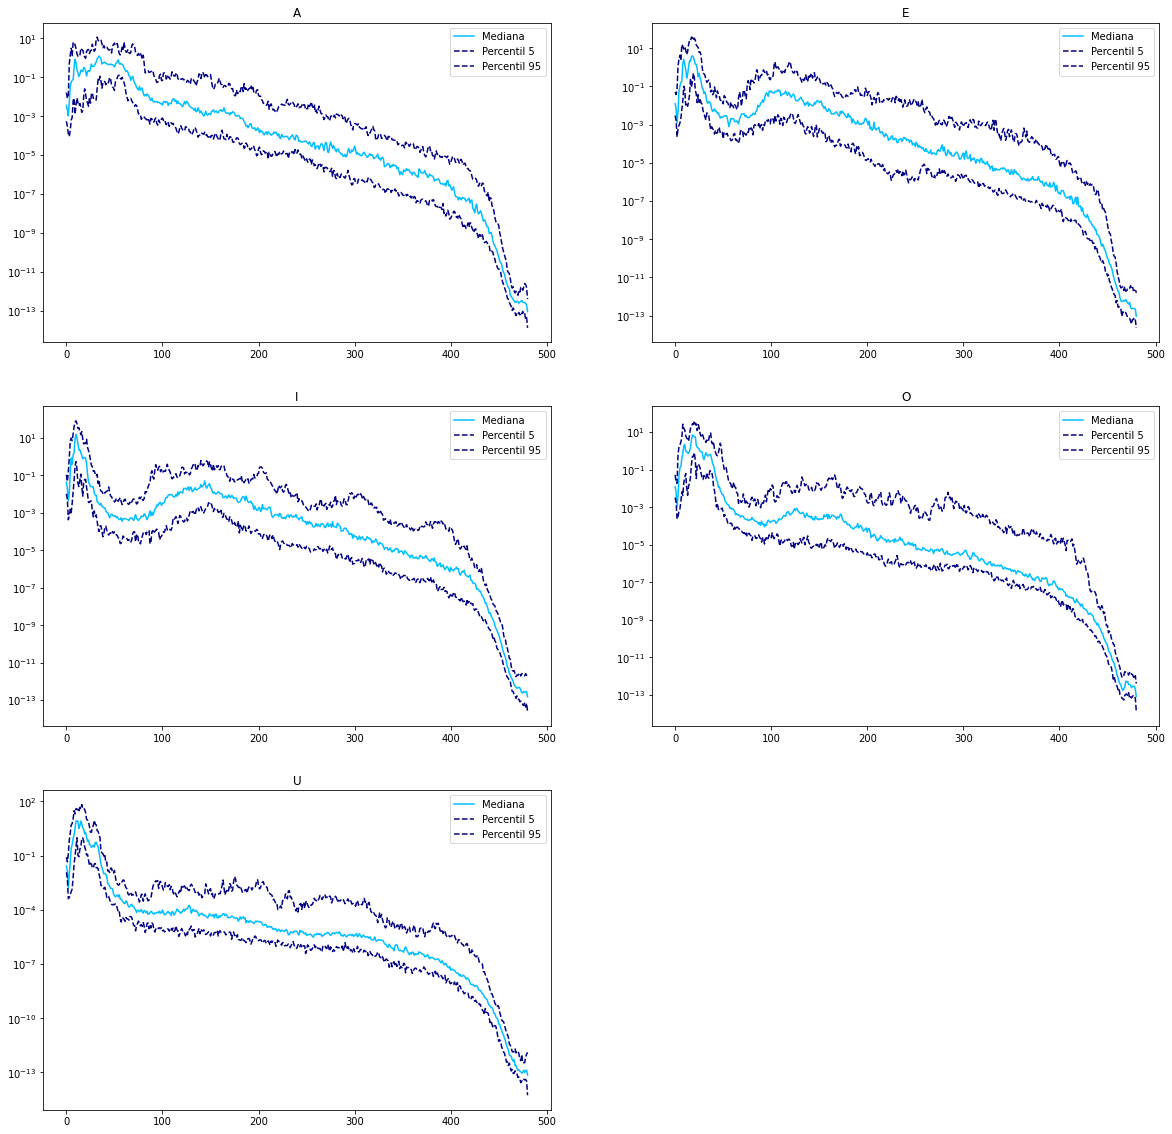

In [31]:
dict_audios = dict_data(final_audios, labels)

fig, axes = plt.subplots(3, 2, figsize=(20, 20))
fig.delaxes(ax=axes[2, 1])

for i, v in enumerate(dict_audios.keys()):
    med = np.median(dict_audios[v], axis=0)
    per5 = np.percentile(dict_audios[v], 5, axis=0)
    per95 = np.percentile(dict_audios[v], 95, axis=0)
    if i % 2 == 0:
        axes[i//2,0].semilogy(med, c='deepskyblue')
        axes[i//2,0].semilogy(per5, 'c--', c='navy')
        axes[i//2,0].semilogy(per95, 'c--', c='navy')
        axes[i//2,0].set_title(v)
        axes[i//2,0].legend(['Mediana', 'Percentil 5', 'Percentil 95'])
    else:
        axes[i//2,1].semilogy(med, c='deepskyblue')
        axes[i//2,1].semilogy(per5, 'c--', c='navy')
        axes[i//2,1].semilogy(per95, 'c--', c='navy')
        axes[i//2,1].set_title(v)
        axes[i//2,1].legend(['Mediana', 'Percentil 5', 'Percentil 95'])

Para un mejor tratamiento de los datos y evitar problemas con respecto a las dimensiones de los mismos, se decide tomar como referencia la media de la duración de los audios, con el fin de ya sea acortar o alargar los mismos hasta dicho valor. Para ello es necesario definir un sample rate, tomamos por defecto $22050$. El cual es el recomendado por $\texttt{python}$ para el tratamiento de audios de voz (consultado documentación función *stft* de la librería *librosa*).

In [32]:
mean_ = np.mean(audios_duration); mean_

0.2780744316842627

In [33]:
new_audios = []
sample_rate = 22050

# Changing the audios 

for audio in final_audios:
  max_ =  int(mean_ * sample_rate)
  if audio.shape[0] > max_:
    new_audios.append(audio[:max_])
  else:
    new_audios.append(librosa.effects.time_stretch(audio, rate = audio.shape[0]/max_))

In [34]:
print('Dimensión datos: ', np.array(new_audios).shape)

Dimensión datos:  (279, 6131)


Finalmente, fueron realizados los espectogramas de cada uno de los audios, puesto que los audios son representados en ventanas de tiempo, donde cada ventana o intervalo de tiempo es tratado con la transformada de Fourier permitiendo así una mejor representación de la señal de audio tanto visual como computacional. Lo cual implica un mejor procesamiento de los datos en la red neuronal. Dichos datos son en $3$ dimensiones los cuales dan características de la frecuencia e intensidad de la señal.

In [35]:
spectograms = []
fourier_t = []

for audio in new_audios:
  fourier_ = librosa.stft(audio, n_fft=512)
  mag, _ = librosa.magphase(fourier_)
  mel_ = librosa.feature.melspectrogram(S=mag, sr=sample_rate, n_fft=512, hop_length=23)
  spect = librosa.amplitude_to_db(mel_, ref=np.min)
  spectograms.append(spect)
  fourier_t.append(fourier_)

In [36]:
print('Dimensión final información: ', np.array(spectograms).shape)

Dimensión final información:  (279, 128, 48)


Definición dataset con *pandas*. Ingresando los datos recolectados previamente con los espectogramas.

In [37]:
data_ = []

for i in range(len(spectograms)):
  data_.append([spectograms[i], labels[i]])

df = pd.DataFrame(data_, columns=['data', 'label'])
df.head()

,data,label
0,"[[43.609383, 30.902885, 45.18984, 50.017975, 5...",0
1,"[[53.090385, 48.22914, 51.91562, 54.09762, 47....",0
2,"[[67.91579, 64.33328, 61.874508, 62.69635, 58....",0
3,"[[50.59776, 32.7024, 49.98168, 46.075367, 46.7...",0
4,"[[46.10923, 53.809868, 56.28918, 58.048622, 61...",0


## Pipeline 

Se realiza la partición del dataset en entrenamiento, pruebas y validación. En donde, se considero un $75\%$ de entrenamiento y un $25\%$ de pruebas. 

In [49]:
X = np.array(df['data'].tolist())
Y = np.array(df['label'].tolist())

# Training and test separation
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=10)  

# Training and validation separation
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=0.25, random_state=50)

In [50]:
_, a, b = X_train.shape

Ahora, como se tienen datos en $3$ dimensiones y la red admite solo de $2$ son transformados en $2$ dimensiones. De igual manera, se definen como variables categóricas a las variables que contienen los *labels*.


In [51]:
# Reshape X data
X_train = X_train.reshape((len(X_train), a*b))
X_validation = X_validation.reshape((len(X_validation), a*b))
X_test = X_test.reshape((len(X_test), a*b))

# Categorical Y data
Y_train = to_categorical(Y_train)
Y_validation = to_categorical(Y_validation)
Y_test = to_categorical(Y_test)

Para el modelo, se tomo una red neuronal de una capa oculta con función de activación *sigmoid*. Una capa de salida de $5$ neuronas, ya que se busca clasificar un audio entre una de las cinco vocales. Adicionalmente, se toma como optimizador el algoritmo del gradiente descendiente con taza de aprendizaje del $0.0005$.

In [52]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(300, activation='sigmoid', input_dim=X_train.shape[1] ))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

opt = SGD(learning_rate=0.0005)
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=['accuracy'])

Se entrena el modelo usando $500$ epocas y los vectores de validación definidos previamente.

In [53]:
history = model.fit(X_train, Y_train, validation_data=(X_validation, Y_validation), epochs=500)

Epoch 1/500
5/5 [==============================] - 1s 62ms/step - loss: 1.5293 - accuracy: 0.3718 - val_loss: 1.3990 - val_accuracy: 0.5472
Epoch 2/500
5/5 [==============================] - 0s 18ms/step - loss: 1.3675 - accuracy: 0.6090 - val_loss: 1.3689 - val_accuracy: 0.6038
Epoch 3/500
5/5 [==============================] - 0s 18ms/step - loss: 1.3684 - accuracy: 0.5833 - val_loss: 1.3223 - val_accuracy: 0.6981
Epoch 4/500
5/5 [==============================] - 0s 17ms/step - loss: 1.3271 - accuracy: 0.6410 - val_loss: 1.3140 - val_accuracy: 0.6415
Epoch 5/500
5/5 [==============================] - 0s 18ms/step - loss: 1.2893 - accuracy: 0.6603 - val_loss: 1.2645 - val_accuracy: 0.6981
Epoch 6/500
5/5 [==============================] - 0s 18ms/step - loss: 1.2839 - accuracy: 0.7179 - val_loss: 1.2711 - val_accuracy: 0.7925
Epoch 7/500
5/5 [==============================] - 0s 18ms/step - loss: 1.2891 - accuracy: 0.7244 - val_loss: 1.2555 - val_accuracy: 0.6981
Epoch 8/500
5/5 [===

## Comportamiento de la red

Primero, la matriz de confusión de los datos de prueba. Se encuentra que clasifica correctamente todas las A's y O's. Sin embargo, confunde ciertas E's con I's o viceversa. Por otra parte, es posible que se confundan las U's con O's. Esto se debe a la similitud en las señales de las vocales, lo podemos observar en las gráficas vistas previamente del rango del umbral. Donde es posible observar similitudes entre las vocales E e I y también O y U, debido al comportamiento de las mismas. 

Text(83.40000000000006, 0.5, 'True')

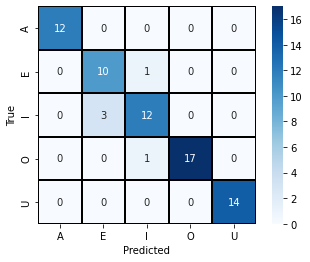

In [54]:
y_pred = model.predict(X_test)
cm = confusion_matrix(np.argmax(Y_test, axis=1).tolist(),np.argmax(y_pred, axis=1).tolist())
sns.heatmap(cm, cmap='Blues', annot=True, square = True, linewidths = 1, linecolor = 'black',
             yticklabels=["A","E","I","O","U"], xticklabels=["A","E","I","O","U"])
plt.xlabel("Predicted")
plt.ylabel("True")

En la gráfica, de precisión, se observa como el entrenamiento se empieza a ajustar a la red de mejor manera que la validación. Asimismo, se aproximan rapidamente hacia el $0.8$ alrededor de la epoca $50$, i.e., puede que no sean necesarias la cantidad de epocas propuestas, la red podría trabajar de igual manera con aproximadamente $250$ epocas, ya que en estos valores tiende a acercarse la validación al $0.95$.

Por otro lado, no se presenta *overfitting* ni *underfitting*, esto se identifica en la gráfica, ya que no se visualizan saltos en la precisión de la validación y el entrenamiento, en cambio, estos mantienen un ascenso gradual, descartando así *underfitting*. Igualmente, la precisión de los datos de entrenamiento aumenta junto con la precisión de los datos de validación, significando así la no presencia de *overfitting*.

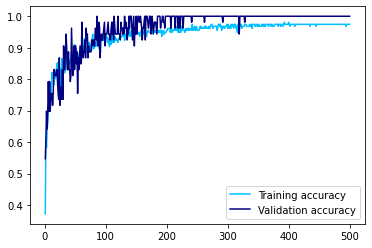

In [55]:
epochs = range(1, 501)
plt.plot(epochs, history.history['accuracy'], c='deepskyblue', label='Training accuracy')
plt.plot(epochs, history.history['val_accuracy'], c='Navy', label='Validation accuracy')
plt.legend()

Ahora, en la gráfica de perdida se evidencia una pequeña distancia entre las curvas de entrenamiento y validación, siendo esto positivo para la red. También, ambas curvas decrecen hasta $0.4$ paulatinamente.

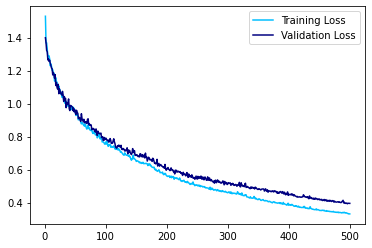

In [56]:
epochs = range(1, 501)
plt.plot(epochs, history.history['loss'], c='deepskyblue', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], c='Navy', label='Validation Loss')
plt.legend()

## Pruebas

Es definida la siguiente función que recibe como parametro la ruta en donde se encuentra el audio y realiza el proceso hecho anteriormente para este con el fin de que pueda ser aceptado en la red para su predicción.

In [57]:
def predict_value(path):
  data_ = librosa.load(path)
  audio = librosa.effects.trim(data_[0], top_db=8)[0] 
  t_ = librosa.get_duration(audio)
  audio = norm_(audio)
  max_ =  int(mean_ * sample_rate)
  if audio.shape[0] > max_:
      audio = audio[:max_]
  else:
      audio = librosa.effects.time_stretch(audio, rate = audio.shape[0]/max_)

  fourier_ = librosa.stft(audio, n_fft=512)
  mag, _ = librosa.magphase(fourier_)
  mel_ = librosa.feature.melspectrogram(S=mag, sr=sample_rate, n_fft=512, hop_length=23)
  spect = librosa.amplitude_to_db(mel_, ref=np.min)
  input = np.reshape(spect, (1,spect.shape[0]*spect.shape[1]))

  pred = model.predict(input)
  value = np.argmax(pred,axis=1)

  return vowels[value[0]]

Para las pruebas se toma un dataset distinto al usado en el entrenamiento de la red, en donde se realiza una predicción para cada uno de los audios almacenados. Dicha información es guardada en un diccionario.

In [58]:
dict_predictions = {'A': [], 'E': [], 'I': [], 'O': [], 'U': []}
path = '/content/drive/MyDrive/Proyecto2/Letras/'

for v in dict_predictions.keys():
  for route in os.listdir(path + v):
    predict = predict_value(path + v + '/' + route)
    dict_predictions[v].append(predict)

Finalmente, se muestra el desempeño de la red con respecto a cada vocal. El cual es bastante bueno! :)

In [59]:
print('------------')
for v in dict_predictions.keys():
  print()
  total = len(dict_predictions[v])
  clasified =  Counter(dict_predictions[v])
  print('Se clasificaron correctamente {0} {1}s de {2}.'.format(clasified[v], v, total))
  print()
  print('En general, fueron clasificadas de la siguiente manera: {}'.format(clasified))
  print()
  print('------------')

------------

Se clasificaron correctamente 56 As de 66.

En general, fueron clasificadas de la siguiente manera: Counter({'A': 56, 'O': 6, 'U': 3, 'I': 1})

------------

Se clasificaron correctamente 49 Es de 66.

En general, fueron clasificadas de la siguiente manera: Counter({'E': 49, 'I': 12, 'U': 3, 'O': 1, 'A': 1})

------------

Se clasificaron correctamente 50 Is de 66.

En general, fueron clasificadas de la siguiente manera: Counter({'I': 50, 'E': 10, 'U': 5, 'O': 1})

------------

Se clasificaron correctamente 41 Os de 66.

En general, fueron clasificadas de la siguiente manera: Counter({'O': 41, 'U': 15, 'A': 10})

------------

Se clasificaron correctamente 51 Us de 66.

En general, fueron clasificadas de la siguiente manera: Counter({'U': 51, 'O': 13, 'I': 2})

------------


## Sección teórica

### 1. ¿Qué puede concluir del comportamiento de la red y los datos proporcionados?

La red tiene un gran desempeño, esto se evidencia en las pruebas realizadas tanto en la matriz de confusión como en el *test* con cada uno de los audios tomados de la base de datos de pruebas. En donde, el peor rendimiento se evidencia en la vocal *I*, pues fueron clasificados correctamente $42$ audios de $66$, siendo confundidos, en general, con la vocal *E*.

Dichos resultados se deben al procesamiento de los datos realizados antes del entrenamiento. Los cuales permiten encapsular y generalizar de gran manera la información tomada para el entrenamiento. También, las similitudes con las señales de cada vocal presentadas por medio de las gráficas, se constata en las pruebas, pues las vocales *E* e *I*, *U* y *O* son confundidas en la red.

### 2. ¿Qué criterio utilizó para seleccionar la arquitectura de la red?

Se utilizó una red neuronal con una capa oculta. Se determinó utilizar una capa oculta solamente, ya que hay realizar distintas pruebas para obtener el mejor comportamiento de la red se vió que al aumentar el número de capas, puede que la precisión del modelo se afecte. Sin embargo, es posible adaptar el modelo a las mismas.

Para agregar, se tomo como optimizador, el gradiente descendiente, y en la última capa se toman 5 neuronas, ya que se buscan clasificar las 5 vocales, con la activación *softmax* (activación multi-clase). Finalmente, el número de neuronas se obtuvo al ir aumentando estas hasta el punto en el que no se presentará *overfitting* ni *underfitting*.

### 3. ¿Tiene la red el comportamiento esperado?, si no es así, ¿A qué cree que se debe esto?

La red tiene el comportamiento esperado, es capaz de diferenciar en la gran mayoria de los casos cada una de las vocales, en el *testing* se obtiene una clasificación optima en más del $60\%$ de los casos. Por otra parte, se esperaba que confundiera las vocales *E* e *I* y *O* y *U*, debido a la similitud en sus señales. No obstante, no fue previsto que la vocal *A* fuera clasificada como cualquiera de las otras vocales (veáse sección de pruebas). Empero, la confusión con la vocal *O* puede ser causada a que ambas con vocales abiertas. 

### 4. ¿Qué le mejoraria al modelo que usted diseño?, ¿Cómo implementaría esas mejoras?

Al modelo se le implementarían las siguientes mejoras: 

*   Explorar más funciones de activación para mejorar el accuracy o explorar nuevos comportamientos en la red.
*   Tomar mayor cantidad de muestras, en un ambiente estandarizado. Para tener una mayor uniformidad en los datos.
*   Implementar regularizaciones a la red.
*   Determinar un mejor procesamiento de los datos el cual ayude a evitar confusiones entre las vocales.
*   Implementar una interfaz interactiva con el usuario.




## Datasets

1.   Bases de datos proporcionadas por estudiantes de pregrado, que cursaron la asignatura en 2021-2, o que lo estan cursando en 2022-1.

